In [3]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import diags, spdiags, csc_matrix

def create_matrix_original(n=5):
    a = np.zeros((n-1, n-1))
    idx = np.arange(n-1)
    a[idx, idx] = -4
    a[idx[:-1], idx[:-1]+1] = 1
    a[idx[1:], idx[1:]-1] = 1
    
    m = np.zeros(((n-1)*n, (n-1)*n))
    for i in range(n):
        m[i*(n-1):(i+1)*(n-1), i*(n-1):(i+1)*(n-1)] = a
    
    idx = np.arange(m.shape[0])
    m[idx[:-n+1], idx[:-n+1] + n-1] = 1
    m[idx[n-1:], idx[n-1:] - n+1] = 1
    return m

def create_matrix_csc(n=5):
    block_size = n-1
    total_size = block_size * n
    
    rows = []
    cols = []
    data = []
    
    for k in range(n):
        for i in range(block_size):
            rows.append(k*block_size + i)
            cols.append(k*block_size + i)
            data.append(-4)
            
            if i < block_size-1:
                rows.append(k*block_size + i)
                cols.append(k*block_size + i + 1)
                data.append(1)
            
            if i > 0:
                rows.append(k*block_size + i)
                cols.append(k*block_size + i - 1)
                data.append(1)
    
    for i in range(total_size - (n-1)):
        rows.append(i)
        cols.append(i + (n-1))
        data.append(1)
        
        rows.append(i + (n-1))
        cols.append(i)
        data.append(1)
    
    return csc_matrix((data, (rows, cols)), shape=(total_size, total_size))

def create_matrix_diags(n=5):

    block_size = n-1
    total_size = block_size * n
    
    
    diagonals = [-4 * np.ones(total_size),
                 np.ones(total_size - 1),
                 np.ones(total_size - 1),
                 np.ones(total_size - block_size),
                 np.ones(total_size - block_size)]
    
    offsets = [0, 1, -1, block_size, -block_size]
    
    return diags(diagonals, offsets, shape=(total_size, total_size), format='csc')

In [4]:
from scipy.linalg import solve_banded
import scipy.sparse.linalg as spla
from numba import njit, prange

def method1_solve_banded(m):

    m = m_csc.toarray()
    total_size = m.shape[0]
    b = np.zeros(total_size)
    b[total_size//2] = -1
    l = 0
    u = 0
    for i in range(total_size):
        for j in range(total_size):
            if m[i, j] != 0:
                offset = j - i
                l = max(l, -offset if offset < 0 else 0)
                u = max(u, offset if offset > 0 else 0)
    ab = np.zeros((l + u + 1, total_size))
    for i in range(total_size):
        for j in range(total_size):
            if m[i, j] != 0:
                offset = j - i
                row = u - offset
                ab[row, j if offset >= 0 else i] = m[i, j]
    x = solve_banded((l, u), ab, b)
    return x

def method2_spsolve(m):

    total_size = m.shape[0]
    b = np.zeros(total_size)
    b[total_size//2] = -1
    x = spla.spsolve(m_csc, b)
    return x

@njit(parallel=True)
def gauss_seidel_numba_parallel(A, f, eps=1e-6, MAX_ITER=100000):

    n = f.shape[0]
    x_prev = np.ones(f.shape) * 2
    x_curr = np.copy(x_prev)
    for k in range(1, MAX_ITER + 1):
        x_prev[:] = x_curr[:]
        for i in prange(n):
            s_left = 0.0
            for j in range(i):
                s_left += A[i, j] * x_curr[j]
            s_right = 0.0
            for j in range(i + 1, n):
                s_right += A[i, j] * x_prev[j]
            x_curr[i] = (f[i] - s_left - s_right) / A[i, i]
        diff_sq = 0.0
        for i in prange(n):
            diff = x_curr[i] - x_prev[i]
            diff_sq += diff * diff
        if diff_sq < eps * eps:
            break
    return x_curr

def method3_gauss_seidel(m, eps=1e-6):

    m = m.toarray()
    total_size = m.shape[0]
    b = np.zeros(total_size)
    b[total_size//2] = -1
    x = gauss_seidel_numba_parallel(m, b, eps=eps)
    return x

n = 10
eps = 1e-6

m_orig = create_matrix_original(n)
m_csc = create_matrix_csc(n)
m_diags = create_matrix_diags(n)

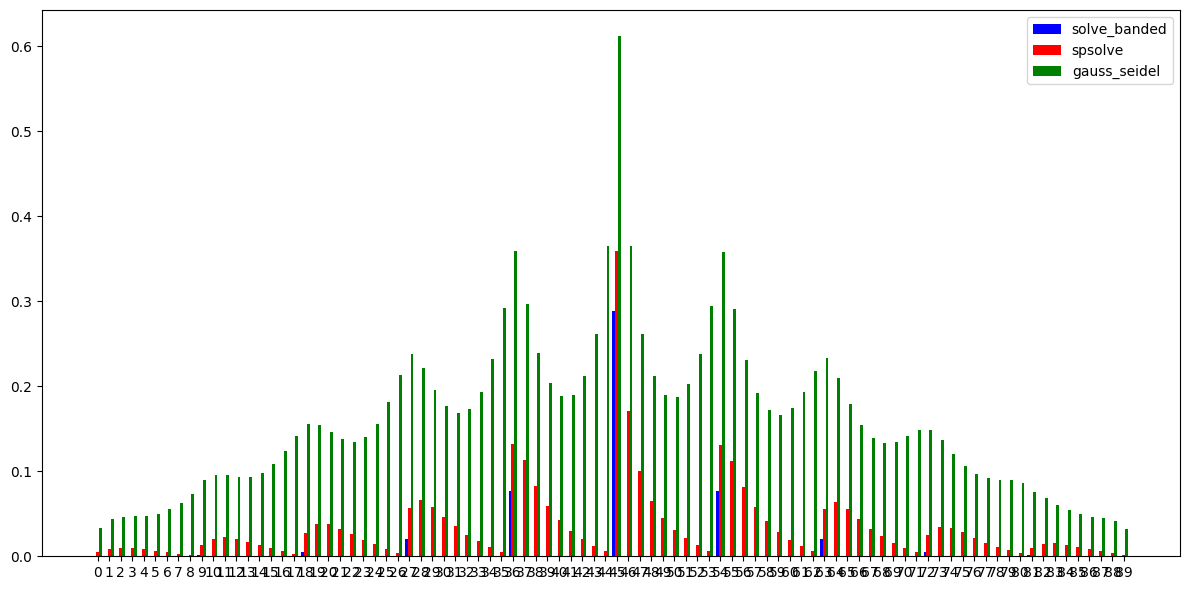

In [7]:
import matplotlib.pyplot as plt

x1 = method1_solve_banded(m_diags)
x2 = method2_spsolve(m_diags)
x3 = method3_gauss_seidel(m_diags, eps)

fig, ax = plt.subplots(figsize=(12, 6))

x_pos = np.arange(n * (n-1))
width = 0.25

bars1 = ax.bar(x_pos - width, x1, width, label='solve_banded', color='blue')
bars2 = ax.bar(x_pos, x2, width, label='spsolve', color='red')
bars3 = ax.bar(x_pos + width, x3, width, label='gauss_seidel', color='green')

ax.set_xticks(x_pos)
ax.legend()

plt.tight_layout()
plt.show()

In [24]:
def schulz_inv(A, m=2, max_iter=100, tol=1e-10, X0=None):
    n = A.shape[0]
    I = np.eye(n)
    
    if X0 is None:
        norm_A = np.linalg.norm(A, 1) * np.linalg.norm(A, np.inf)
        if norm_A == 0:
            norm_A = 1.0
        X = A / norm_A
    else:
        X = X0.copy()
    
    for k in range(max_iter):
        Psi = I - A @ X
        res_norm = np.linalg.norm(Psi, 'fro')
        if res_norm < tol:
            return X, k
        
        S = I.copy()
        Psi_power = Psi.copy()
        for i in range(1, m+1):
            S += Psi_power
            if i < m:
                Psi_power = Psi_power @ Psi
        
        X = X @ S
    
    return X, max_iter

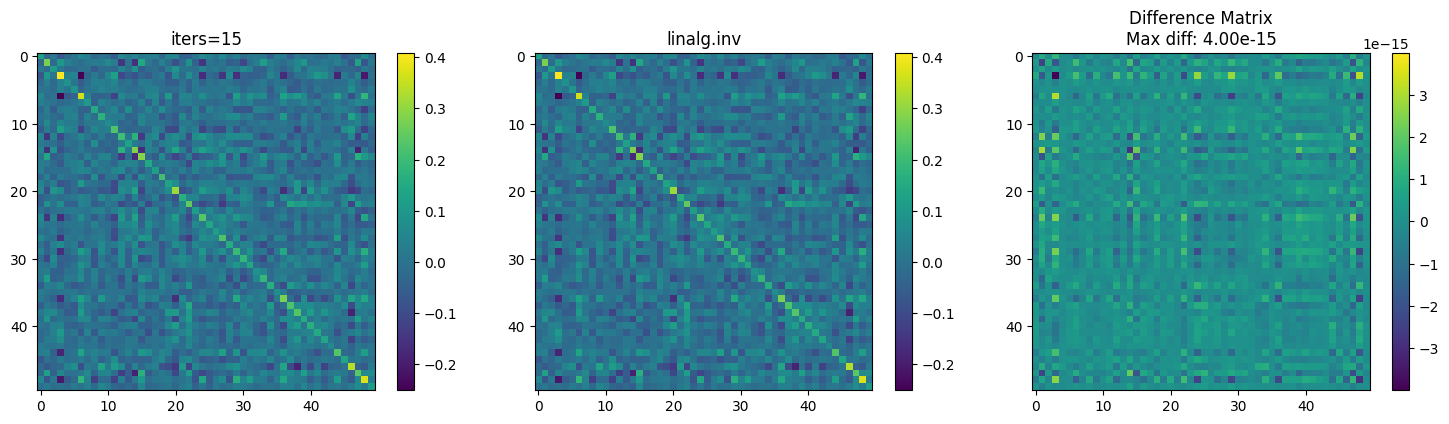

In [25]:
np.random.seed(42)
n = 50
A = np.random.randn(n, n)
A = A @ A.T + 0.5 * np.eye(n)

X_schulz, iters = schulz_inv(A, m=2, tol=1e-5, max_iter=20)
X_exact = np.linalg.inv(A)

diff_matrix = X_schulz - X_exact
max_diff = np.max(np.abs(diff_matrix))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

im1 = axes[0].imshow(X_schulz)
axes[0].set_title(f'iters={iters}')
plt.colorbar(im1, ax=axes[0])

im2 = axes[1].imshow(X_exact)
axes[1].set_title('linalg.inv')
plt.colorbar(im2, ax=axes[1])

im3 = axes[2].imshow(diff_matrix, vmin=-max_diff, vmax=max_diff)
axes[2].set_title(f'Difference Matrix\nMax diff: {max_diff:.2e}')
plt.colorbar(im3, ax=axes[2])

plt.tight_layout()
plt.show()

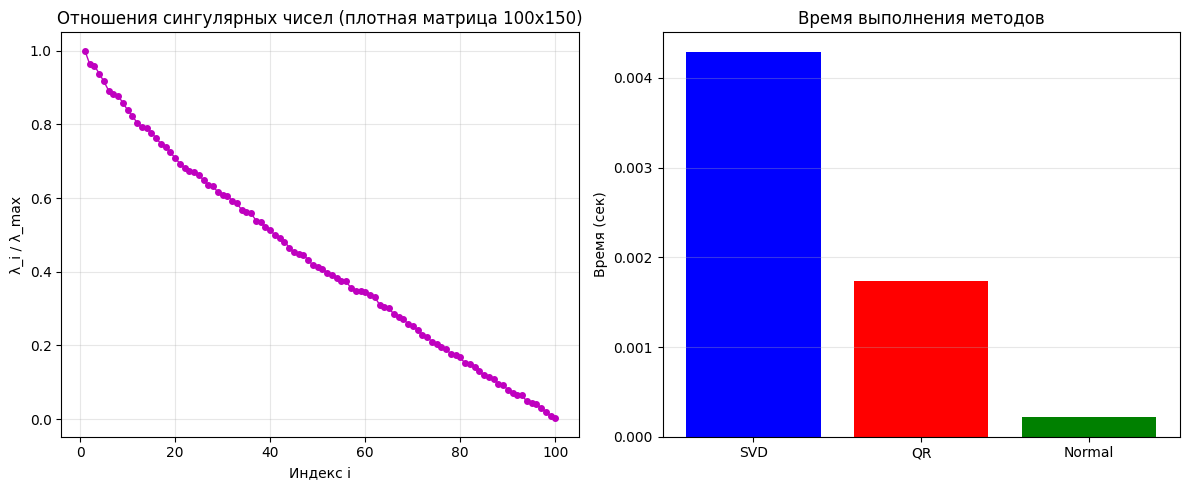

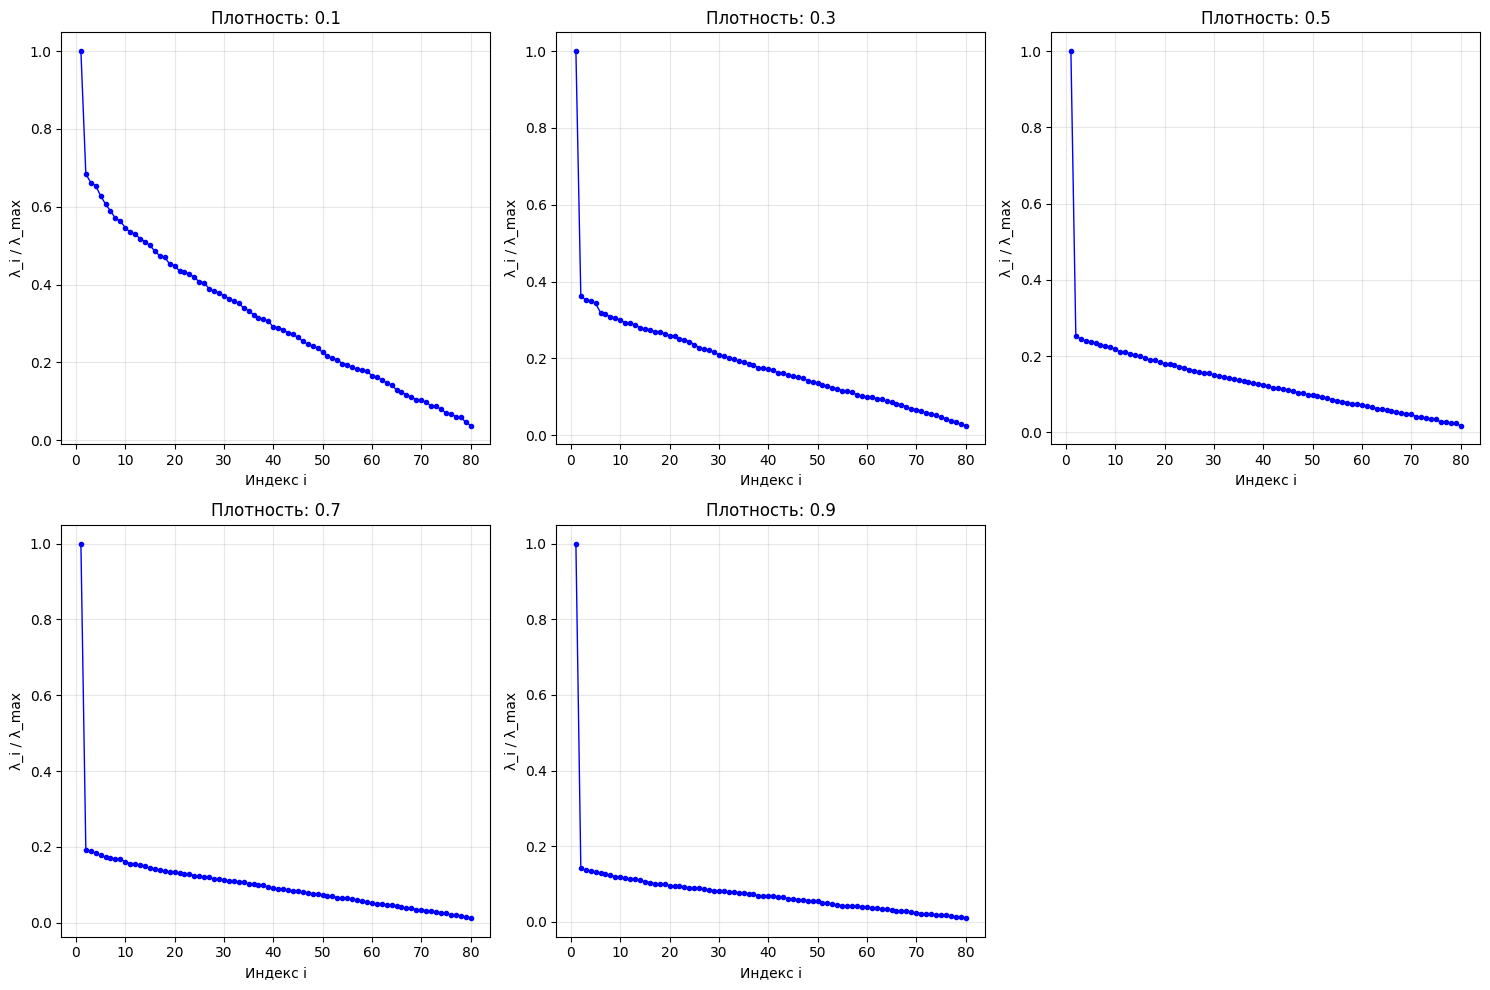

In [45]:
import numpy as np
import scipy as sp
import scipy.sparse
import matplotlib.pyplot as plt
import time

def pseudoinverse_svd(A, eps=1e-6):
    U, s, Vh = np.linalg.svd(A, full_matrices=False)
    mask = s > eps
    s_inv = np.zeros_like(s)
    s_inv[mask] = 1.0 / s[mask]
    A_pinv = Vh.T @ np.diag(s_inv) @ U.T
    cond = s[0] / s[-1] if s[-1] > 0 else np.inf
    return A_pinv, cond, s

def lstq_svd(A, b):
    A_pinv, _, _ = pseudoinverse_svd(A)
    return A_pinv @ b

def lstq_qr(A, b):
    Q, R = np.linalg.qr(A, mode='reduced')
    return sp.linalg.solve_triangular(R, Q.T @ b, lower=False)

def lstq_normal(A, b):
    return np.linalg.solve(A.T @ A, A.T @ b)

m, n = 100, 100
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.01 * np.random.randn(m)

start = time.time()
x_svd = lstq_svd(A, b)
time_svd = time.time() - start

start = time.time()
x_qr = lstq_qr(A, b)
time_qr = time.time() - start

start = time.time()
x_normal = lstq_normal(A, b)
time_normal = time.time() - start

_, _, s = pseudoinverse_svd(A)
lambda_ratios = s / s[0]

fig1, axes1 = plt.subplots(1, 2, figsize=(12, 5))

axes1[0].plot(range(1, len(lambda_ratios)+1), lambda_ratios, 'mo-', markersize=4, linewidth=1)
axes1[0].set_xlabel('Индекс i')
axes1[0].set_ylabel('λ_i / λ_max')
axes1[0].grid(True, alpha=0.3)
axes1[0].set_title('Отношения сингулярных чисел (плотная матрица 100x150)')

axes1[1].bar(['SVD', 'QR', 'Normal'], [time_svd, time_qr, time_normal], color=['blue', 'red', 'green'])
axes1[1].set_ylabel('Время (сек)')
axes1[1].set_title('Время выполнения методов')
axes1[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

densities = [0.1, 0.3, 0.5, 0.7, 0.9]
shape = (80, 100)

fig2, axes2 = plt.subplots(2, 3, figsize=(15, 10))
axes2 = axes2.flatten()

for idx, density in enumerate(densities):
    sparse_mat = sp.sparse.rand(*shape, density=density, random_state=42)
    A_sparse = sparse_mat.toarray() + 0.001 * np.random.randn(*shape)
    
    _, _, s_sparse = pseudoinverse_svd(A_sparse)
    lambda_ratios_sparse = s_sparse / s_sparse[0]
    
    axes2[idx].plot(range(1, len(lambda_ratios_sparse)+1), lambda_ratios_sparse, 'bo-', markersize=3, linewidth=1)
    axes2[idx].set_xlabel('Индекс i')
    axes2[idx].set_ylabel('λ_i / λ_max')
    axes2[idx].grid(True, alpha=0.3)
    axes2[idx].set_title(f'Плотность: {density}')

axes2[5].axis('off')
plt.tight_layout()
plt.show()

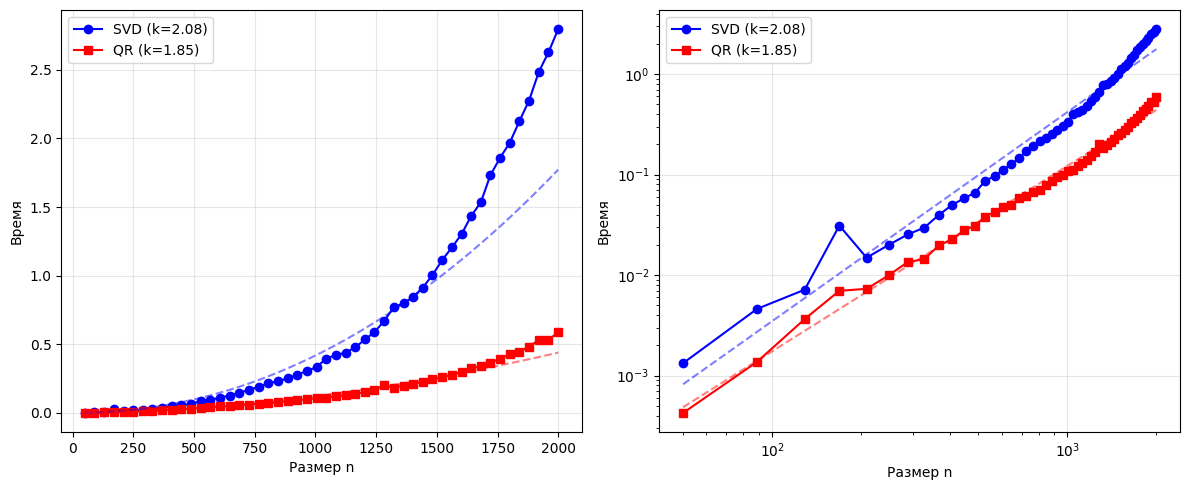

In [56]:
def analyze_time_asymptotics():
    ns = np.linspace(50, 2000, 50, dtype=int)
    times_svd = []
    times_qr = []
    
    for n in ns:
        m = int(n * 1.2)
        A = np.random.randn(m, n)
        b = np.random.randn(m)
        
        start = time.time()
        _ = lstq_svd(A, b)
        times_svd.append(time.time() - start)
        
        start = time.time()
        _ = lstq_qr(A, b)
        times_qr.append(time.time() - start)
    
    log_n = np.log(ns)
    log_t_svd = np.log(times_svd)
    log_t_qr = np.log(times_qr)
    
    coeff_svd = np.polyfit(log_n, log_t_svd, 1)
    coeff_qr = np.polyfit(log_n, log_t_qr, 1)
    
    fit_svd = np.exp(coeff_svd[1]) * ns**coeff_svd[0]
    fit_qr = np.exp(coeff_qr[1]) * ns**coeff_qr[0]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].plot(ns, times_svd, 'b-o', label=f'SVD (k={coeff_svd[0]:.2f})')
    axes[0].plot(ns, times_qr, 'r-s', label=f'QR (k={coeff_qr[0]:.2f})')
    axes[0].plot(ns, fit_svd, 'b--', alpha=0.5)
    axes[0].plot(ns, fit_qr, 'r--', alpha=0.5)
    axes[0].set_xlabel('Размер n')
    axes[0].set_ylabel('Время')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].loglog(ns, times_svd, 'b-o', label=f'SVD (k={coeff_svd[0]:.2f})')
    axes[1].loglog(ns, times_qr, 'r-s', label=f'QR (k={coeff_qr[0]:.2f})')
    axes[1].loglog(ns, fit_svd, 'b--', alpha=0.5)
    axes[1].loglog(ns, fit_qr, 'r--', alpha=0.5)
    axes[1].set_xlabel('Размер n')
    axes[1].set_ylabel('Время')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

analyze_time_asymptotics()